In [1]:
from AFEP_parse import *

from IPython.display import display, Markdown

import warnings #Suppress future warnings from pandas.
warnings.simplefilter(action='ignore', category=FutureWarning)

# How to Use this Notebook:

## This notebook is specially written for the SAFEP tutorial. 
For more up-to-date and general versions see the SAFEP github.

## This and other SAFEP notebooks make use of pyMBAR and Alchemlyb. 
For more information see Shirts and Chodera (2008), "Statistically optimal analysis of samples from multiple equilibrium states" doi: 10.1063/1.2978177

## User Parameters:
**IMPORTANT: Make sure the temperature matches the temperature used to run the simulations.** <br>
The decorrelate flag should be set to True for general use. <br>
The detectEQ (automatic equilibrium detection) flag is optional. If you have very poor convergence but believe your system is well-sampled, you may wish to try it.

In [2]:
temperature = 300
decorrelate = True #Flag for automatic decorrelation
detectEQ = False #Flag for automatic equilibrium detection
radius = 1.5 #Radius of the spherical restraint used for the DBC TI calculation

***
# Process the Bound Data

In [3]:
path='../AFEP-Bound-Decoupling/output/'
filename='*.fepout' #This can be a regex pattern if you have more than one fepout file

RT = 0.00198720650096 * temperature # RT in kcal/mol
fepoutFiles = glob(path+filename)
fepoutFiles = natsorted(fepoutFiles)
#print(f"Will process {len(fepoutFiles)} fepout files")

In [4]:
u_nk, _ = readAndProcess(fepoutFiles, temperature, decorrelate, detectEQ) #u_nk stores the fep data
perWindow, cumulative = doEstimation(u_nk)

Decorrelating samples. Flag='True'


In [5]:
forward, forward_error, backward, backward_error = doConvergence(u_nk) #Used later in the convergence plot

In [6]:
changeAndError = f'\u0394G = {np.round(cumulative.BAR.f.iloc[-1]*RT, 1)}\u00B1{np.round(cumulative.BAR.errors.iloc[-1]*RT, 1)} kcal/mol'
Markdown('<font size=7>{}</font><br/>'.format(changeAndError))

<font size=7>ΔG = 14.9±0.1 kcal/mol</font><br/>

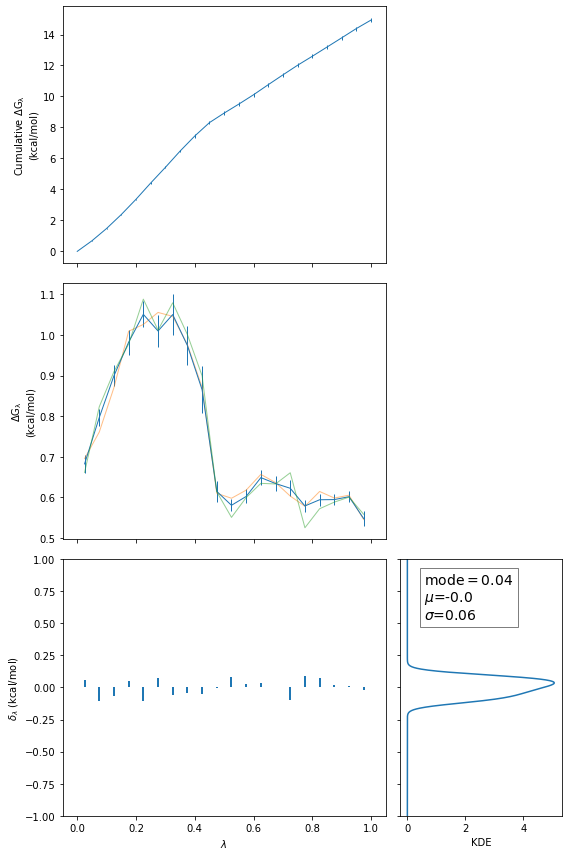

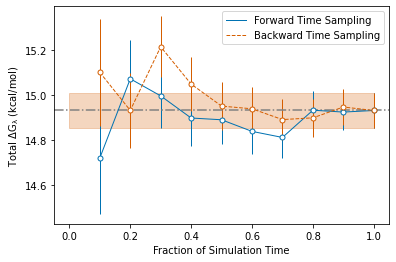

In [7]:
width = 8
height = 4
fig, axes = plotGeneral(cumulative, perWindow, RT, width=width, height=height, PDFtype='KDE')
plt.savefig(f'{path}_bound_generalFigures.pdf')
#plt.savefig(f'{path}dG_{affix}.png', dpi=600)
plt.show()

fig, convAx = plt.subplots(1,1)
convAx = convergencePlot(convAx, forward*RT, forward_error*RT, backward*RT, backward_error*RT)
convAx.set(xlabel='Fraction of Simulation Time', ylabel=r'Total $\rm\Delta G_{\lambda}$ (kcal/mol)')
fig.set_figwidth(width*3/4)
fig.set_figheight(height)
convAx.legend()
plt.savefig(f'{path}_bound_convergence.pdf')
plt.show()

***
# Process the Unbound Data

In [8]:
path='../AFEP-Hydration/'
filename='*.fepout' #This can be a regex pattern if you have more than one fepout file

RT = 0.00198720650096 * temperature # RT in kcal/mol
fepoutFiles = glob(path+filename)
fepoutFiles = natsorted(fepoutFiles)
#print(f"Will process {len(fepoutFiles)} fepout files")

In [9]:
u_nk, _ = readAndProcess(fepoutFiles, temperature, decorrelate, detectEQ) #u_nk stores the fep data
perWindow, cumulative = doEstimation(u_nk)

Decorrelating samples. Flag='True'


In [10]:
forward, forward_error, backward, backward_error = doConvergence(u_nk) #Used later in the convergence plot

In [11]:
changeAndError = f'\u0394G = {np.round(cumulative.BAR.f.iloc[-1]*RT, 1)}\u00B1{np.round(cumulative.BAR.errors.iloc[-1]*RT, 1)} kcal/mol'
Markdown('<font size=7>{}</font><br/>'.format(changeAndError))

<font size=7>ΔG = 4.2±0.1 kcal/mol</font><br/>

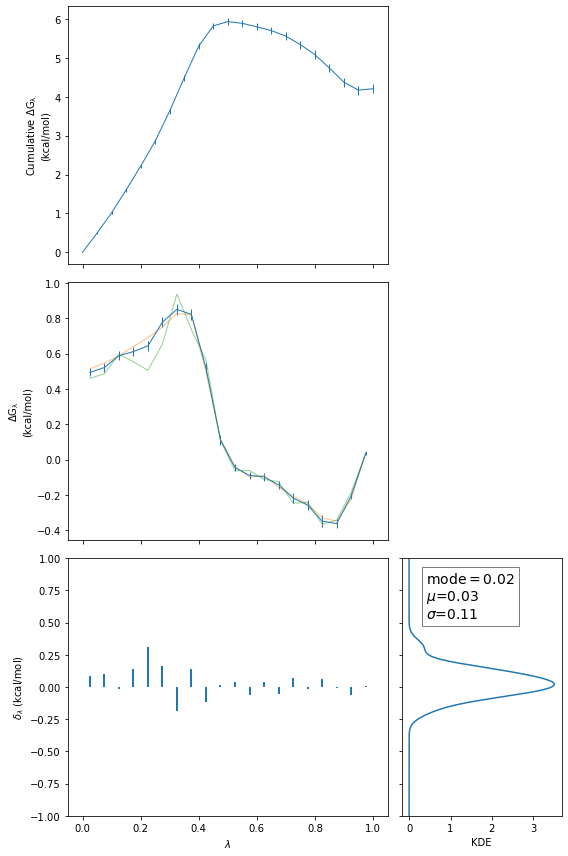

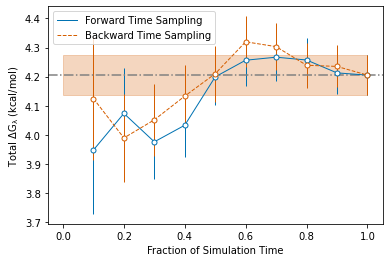

In [12]:
width = 8
height = 4
fig, axes = plotGeneral(cumulative, perWindow, RT, width=width, height=height, PDFtype='KDE')
plt.savefig(f'{path}_bound_generalFigures.pdf')
#plt.savefig(f'{path}dG_{affix}.png', dpi=600)
plt.show()

fig, convAx = plt.subplots(1,1)
convAx = convergencePlot(convAx, forward*RT, forward_error*RT, backward*RT, backward_error*RT)
convAx.set(xlabel='Fraction of Simulation Time', ylabel=r'Total $\rm\Delta G_{\lambda}$ (kcal/mol)')
fig.set_figwidth(width*3/4)
fig.set_figheight(height)
convAx.legend()
plt.savefig(f'{path}_bound_convergence.pdf')
plt.show()

***
# Process the DBC TI calculation

In [69]:
def plotTI(cumulative, perWindow, width=8, height=4, PDFtype='KDE'):
    fig, ((cumAx, del1),( eachAx, del2),(hystAx, pdfAx)) = plt.subplots(3,2, sharex='col', sharey='row', gridspec_kw={'width_ratios': [2, 1]})

    fig.delaxes(del1)
    fig.delaxes(del2)

    # Cumulative change in kcal/mol
    cumAx.plot(cumulative.index, cumulative['mean'], marker=None, linewidth=1, color='black')
    cumAx.plot(cumulative.index, cumulative.ff, marker=None, linewidth=1, alpha=0.5)
    cumAx.plot(cumulative.index, cumulative.fb, marker=None, linewidth=1, alpha=0.5)
    cumAx.set(ylabel=r'Cumulative $\rm\Delta G_{\lambda}$'+'\n(kcal/mol)')

    # Per-window change in kcal/mol
    eachAx.plot(perWindow.index, perWindow.dG_f, marker=None, linewidth=1, alpha=0.5)
    eachAx.plot(perWindow.index, -perWindow.dG_b, marker=None, linewidth=1, alpha=0.5)
    eachAx.set(ylabel=r'$\rm\Delta G_{\lambda}$'+'\n(kcal/mol)')

    
    #Hysteresis Plots
    diff = perWindow.difference
    hystAx.vlines(perWindow.index, np.zeros(len(perWindow)), diff, label="fwd - bwd", linewidth=2)
    hystAx.set(xlabel=r'$\lambda$', ylabel=r'$\delta_\lambda$ (kcal/mol)', ylim=(-1,1))
    
    if PDFtype=='KDE':
        kernel = sp.stats.gaussian_kde(diff)
        pdfX = np.linspace(-1, 1, 1000)
        pdfY = kernel(pdfX)
        pdfAx.plot(pdfY, pdfX, label='KDE')
    elif PDFtype=='PDF':
        pdfX, pdfY = np.histogram(X, nbins=20)
        pdfAx.plot(pdfY, pdfX,  label="Estimated Distribution")
    else:
        raise(f"Error: PDFtype {PDFtype} not recognized")
    
    pdfAx.set(xlabel=PDFtype)

    std = np.std(diff)
    mean = np.average(diff)
    temp = pd.Series(pdfY, index=pdfX)
    mode = temp.idxmax()
    
    textstr = r"$\rm mode=$"+f"{np.round(mode,2)}"+"\n"+fr"$\mu$={np.round(mean,2)}"+"\n"+fr"$\sigma$={np.round(std,2)}"
    props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    pdfAx.text(0.15, 0.95, textstr, transform=pdfAx.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    fig.set_figwidth(width)
    fig.set_figheight(height*3)
    fig.tight_layout()
    
    return fig, [cumAx,eachAx,hystAx,pdfAx] 

In [96]:
def makeHarmonicWall(FC=10, targetFC=None, targetFE=1, upperWalls=1, schedule=None, numSteps=1000, targetEQ=500, name='HW', lowerWalls=None):
    HW = {'name':name, 'targetFC':targetFC, 'targetFE':targetFE, 'FC':FC, 'upperWalls':upperWalls, 'schedule':schedule, 'numSteps':numSteps, 'targetEQ':targetEQ, 'lowerWalls':lowerWalls}
    return HW

def HW_U(HW, coord, L):
    d=0
    if HW['upperWalls'] and coord>HW['upperWalls']:
        d = coord-HW['upperWalls']
    elif HW['lowerWalls'] and coord<HW['lowerWalls']:
        d = coord-HW['lowerWalls']
    
    if d!=0:
        kL = HW['FC']+(L**HW['targetFE'])*(HW['targetFC']-HW['FC'])
        U = kL*d
    else:
        U=0
    return U
    

def makeUFrame(windows=11, samples=10, timeFrequency=100, precision=3, first=0):
    #Make an empty data frame
    lambdas = np.round(np.linspace(0,1,windows), precision)
    dL = np.round(lambdas[1]-lambdas[0], precision)
    times = first+(timeFrequency*np.arange(samples)).astype(int) #steps are integers
    indcs = pd.MultiIndex.from_product([times, lambdas], names = ['time','from-lambda']) #Fully cross the FEPs and the steps like you'd have in raw data (from NAMD at least)
    data = pd.DataFrame(columns=lambdas, index=indcs) #build the dataframe
    data.sort_index(level=1) #make it pretty
    
    return data, dL

def get_TI(dU_Frame, dL):
    #the data frame is organized from index level 1 (fep-lambda) TO column
    #dG will be FROM column TO index
    groups = dU_Frame.groupby(level=1)
    dG=pd.DataFrame([])
    for name, group in groups:
        dG[name] = np.mean(group)*dL

    dG_f=np.diag(dG, k=1)
    dG_b=np.diag(dG, k=-1)

    l=dG.columns.to_list()
    l_mid = np.mean([l[1:],l[:-1]], axis=0)

    return l, l_mid, dG_f, dG_b, dG


def doTI(dU_Frame, dL):
    cumulative = pd.DataFrame()
    perWindow = pd.DataFrame()
        
    l, lmid, dG_fs, dG_bs = get_TI(dU_Frame, dL)

    cumulative['ff'] = np.insert(np.cumsum(dG_fs),0,0)
    cumulative['fb'] = np.insert(-np.cumsum(dG_bs),0,0)
    cumulative['mean'] = np.mean(cumulative, axis=1) 
    cumulative.index = l 

    perWindow['dG_f'] = dG_fs
    perWindow['dG_b'] = dG_bs
    perWindow['difference'] = np.array(dG_fs)+np.array(dG_bs)        
    perWindow.index = lmid
    
    return perWindow.copy(), cumulative.copy()

In [80]:
path = '../RFEP/widerSphere/'
dataTI = pd.read_csv(glob(path+'*.colvars.traj')[0], delim_whitespace=True, names=['step','DBC', 'distance', 'E_dist', 'E_DBC'], comment='#', index_col=0)
dataTI = dataTI[dataTI.index>=1000][1:]
dataTI.index = dataTI.index-1000


Lsched = np.linspace(1,0,41)

DBC = makeHarmonicWall(FC=0, targetFC=200, targetFE=6, upperWalls=1.5, targetEQ=500, numSteps=300000, name='DBC', schedule=Lsched)
Ls = (dataTI.index.values-1)//DBC['numSteps']
Ls[0] = 0

In [81]:
U_Frame, dL = makeUFrame(41, 3000)
dU_Frame = U_Frame.copy()
dataTI['L'] = np.round([DBC['schedule'][i] for i in Ls], 3)
dataTI = dataTI.iloc[1:]

In [93]:
for key, group in dataTI.groupby('L'):
    current = np.nan
    forward = np.nan
    backward = np.nan
    
    current = np.array([HW_U(DBC, coord, key) for coord in group.DBC])
    U_Frame.loc[(slice(None), key), key] = current
    dU_Frame.loc[(slice(None), key), key] = 0
    
    nextKey = np.round(key+dL, 3)
    lastKey = np.round(key-dL, 3)
    if key < 1:
        forward = np.array([HW_U(DBC, coord, nextKey) for coord in group.DBC])
        U_Frame.loc[(slice(None), key), nextKey] = forward
        dU_Frame.loc[(slice(None), key), nextKey] = forward-current
    if key > 0:
        backward = np.array([HW_U(DBC, coord, lastKey) for coord in group.DBC])
        U_Frame.loc[(slice(None), key), lastKey] = backward   
        dU_Frame.loc[(slice(None), key), lastKey] = backward-current   
        
dU_Frame = dU_Frame.sort_index(level=1).sort_index(axis=1)
U_Frame = U_Frame.sort_index(level=1).sort_index(axis=1)

In [111]:
l, lmid, Gf, Gb, dG = get_TI(dU_Frame.astype(np.float64), dL) 

In [86]:
equilibrated = dU_Frame[dU_Frame.index.get_level_values(0) > DBC['targetEQ']]

In [87]:
TIperWindow, TIcumulative = doTI(equilibrated, dL)

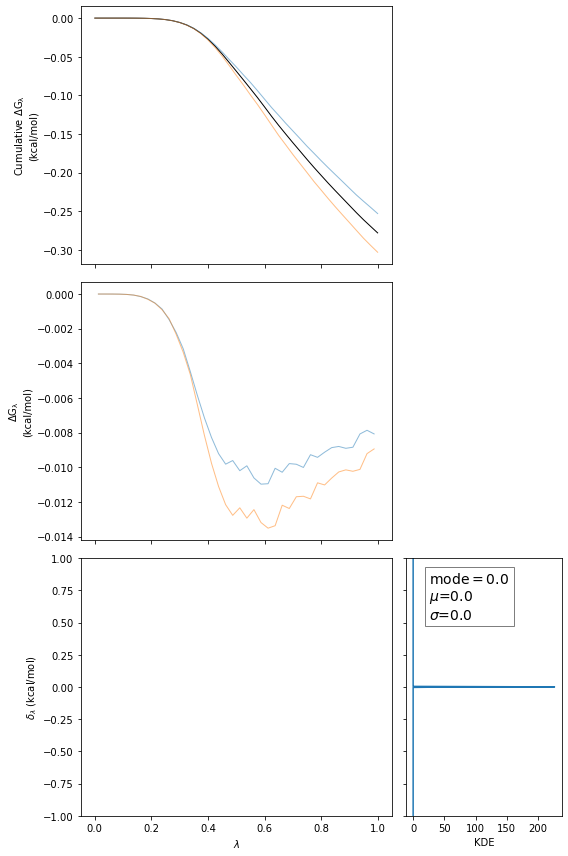

In [88]:
fig, axes = plotTI(TIcumulative, TIperWindow)
plt.show()